In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import matplotlib.pyplot as plt
import seaborn as sns

# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ROG\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ROG\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Load user data from CSV
user_data = pd.read_csv('C:\\Users\\ROG\\OneDrive\\Desktop\\Root\\ML\\user_data.csv')
places_data = pd.read_csv('C:\\Users\\ROG\\OneDrive\\Desktop\\Root\\ML\\places_data.csv')


In [5]:
# NLP Preprocessing function
def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Tokenize text
    words = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in words if word not in stop_words]
    
    return ' '.join(filtered_words)


In [6]:
# Apply preprocessing to the activities and reviews in both datasets
user_data['Preferred Activities'] = user_data['Preferred Activities'].apply(preprocess_text)
places_data['latest_reviews'] = places_data['latest_reviews'].apply(preprocess_text)

# Combine the 'latest_reviews' column for better representation of the place description
places_data['Place Description'] = places_data['latest_reviews']


In [7]:
# Vectorize the text using TF-IDF (Text Frequency - Inverse Document Frequency)
vectorizer = TfidfVectorizer()

# Combine all user activities and place descriptions into a single text corpus for vectorization
combined_text = pd.concat([user_data['Preferred Activities'], places_data['Place Description']])
tfidf_matrix = vectorizer.fit_transform(combined_text)

# Split the matrix back into user and place matrices
user_tfidf = tfidf_matrix[:len(user_data)]
place_tfidf = tfidf_matrix[len(user_data):]


In [8]:
# Build the KNN Model
knn = NearestNeighbors(n_neighbors=5, metric='cosine')
knn.fit(place_tfidf)


NearestNeighbors(metric='cosine')

In [9]:
# Function to recommend places for a given user
def recommend_places(user_index, knn_model, user_tfidf, place_data):
    # Find the top 5 nearest places for the given user index
    distances, indices = knn_model.kneighbors(user_tfidf[user_index], n_neighbors=5)
    
    # Get the recommended places
    recommendations = place_data.iloc[indices[0]]
    return recommendations


In [10]:
# Function to evaluate the recommendation system
def evaluate_recommendations(user_index, knn_model, user_tfidf, place_data, rating_threshold=4.0):
    # Get the recommended places
    recommended_places = recommend_places(user_index, knn_model, user_tfidf, place_data)
    
    # Determine relevant places (places with rating above the threshold)
    relevant_places = place_data[place_data['rating'] > rating_threshold]
    
    # Calculate Precision, Recall, and F1-Score
    recommended_relevant = recommended_places[recommended_places['rating'] > rating_threshold]
    precision = len(recommended_relevant) / len(recommended_places)
    recall = len(recommended_relevant) / len(relevant_places)
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    # Calculate confusion matrix
    tp = len(recommended_relevant)
    fp = len(recommended_places) - tp
    fn = len(relevant_places) - tp
    tn = len(place_data) - (tp + fp + fn)
    
    confusion_matrix = {
        'TP': tp,
        'FP': fp,
        'FN': fn,
        'TN': tn
    }
    
    return precision, recall, f1_score, confusion_matrix


In [12]:
# Function to plot the confusion matrix
def plot_confusion_matrix(confusion_matrix):
    matrix = [
        [confusion_matrix['TP'], confusion_matrix['FP']],
        [confusion_matrix['FN'], confusion_matrix['TN']]
    ]
    labels = ['Recommended & Relevant', 'Recommended & Not Relevant', 'Not Recommended & Relevant', 'Not Recommended & Not Relevant']
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Relevant', 'Not Relevant'], yticklabels=['Recommended', 'Not Recommended'])
    plt.title('Confusion Matrix')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.show()


Evaluation Metrics for Jennifer Quinn:
Precision: 0.4
Recall: 0.006230529595015576
F1-Score: 0.012269938650306749
Confusion Matrix: {'TP': 2, 'FP': 3, 'FN': 319, 'TN': 87}


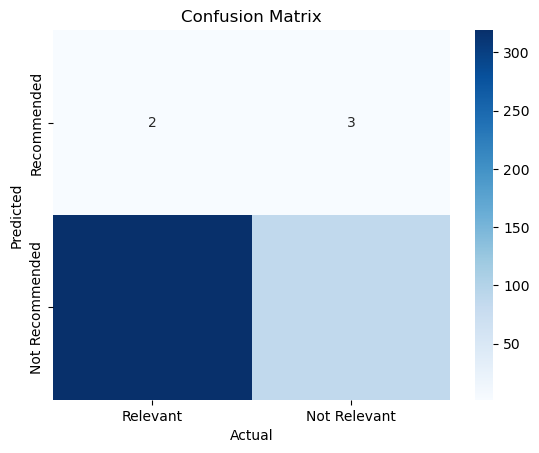

In [13]:
# Example: Evaluate recommendations for the first user (Jennifer Quinn)
precision, recall, f1_score, confusion_matrix = evaluate_recommendations(0, knn, user_tfidf, places_data)
print(f"Evaluation Metrics for {user_data.iloc[0]['Name']}:\nPrecision: {precision}\nRecall: {recall}\nF1-Score: {f1_score}")
print(f"Confusion Matrix: {confusion_matrix}")

# Plot the confusion matrix
plot_confusion_matrix(confusion_matrix)


In [ ]:
Get Recommendations for a Specific User

In [ ]:
# Example: Recommend places for the first user (Jennifer Quinn)
recommended_places = recommend_places(0, knn, user_tfidf, places_data)
print(f"Top 5 recommendations for {user_data.iloc[0]['Name']}:\n", recommended_places[['name', 'rating', 'latest_reviews']])
